# Grama: Fitting Multivariate Distributions

*Purpose*: As we've seen through studying a lot of datasets, many physical systems exhibit variability and other forms of uncertainty. Thus, it is beneficial to be able to *model* uncertainty using distributions. In the previous part of this exercise, we learned how to fit a distribution for a *single* quantity. Now we'll learn how to deal with *multiple* related quantities.

In the final exercise `e-grama08-duu` we'll see how to use a distribution model to do useful engineering work.


## Setup


In [1]:
import grama as gr
DF = gr.Intention()
%matplotlib inline

For this exercise, we'll study a dataset of observations on die cast aluminum parts.


In [2]:
from grama.data import df_shewhart


# Dependency in the wild

We've seen lots of examples of dependency in datasets so far! Any case where we see "patterns" in a scatterplot are examples of some relationship (or dependency) between variables.

As a concrete example, let's take a look at the measured `density` and `hardness` values from the cast aluminum dataset:


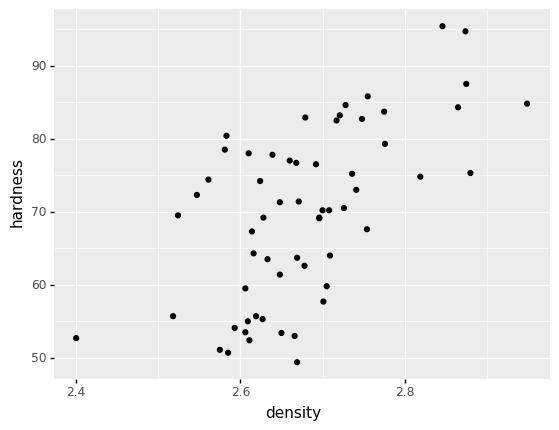

<ggplot: (8744243135091)>

In [3]:
## NOTE: No need to edit
(
    df_shewhart
    >> gr.ggplot(gr.aes("density", "hardness"))
    + gr.geom_point()
)

We can see a positive correlation between the two variables. If we wanted to model the `density` and `hardness` simultaneously, we would need to respect this dependency.

A normal distribution does a *reasonable* job representing both `density` and `hardness` separately.


/home/zach/Git/py_grama/grama/tran_pivot.py:570: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/zach/Bin/anaconda3/envs/evc/lib/python3.9/site-packages/plotnine/facets/facet.py:487: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
/home/zach/Bin/anaconda3/envs/evc/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/zach/Bin/anaconda3/envs/evc/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/zach/Bin/anaconda3/envs/evc/lib/python3.9/site-packages/plotnine/facets/f

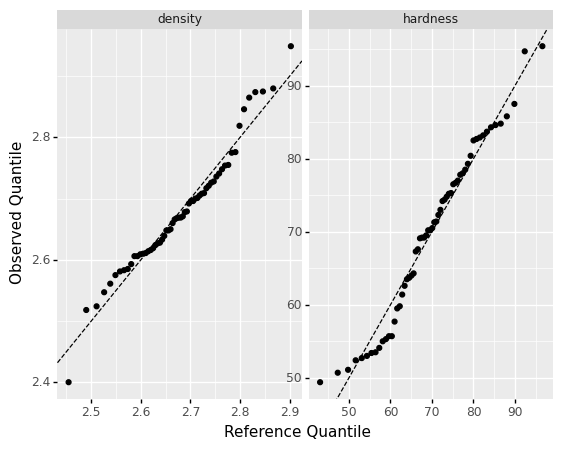

<ggplot: (8744240703419)>

In [4]:
## NOTE: No need to edit
(
    df_shewhart
    >> gr.tf_mutate(
        q_density=gr.qqvals(DF.density, "norm"),
        q_hardness=gr.qqvals(DF.hardness, "norm"),
    )
    >> gr.tf_rename(
        v_density="density",
        v_hardness="hardness",
    )
    >> gr.tf_pivot_longer(
        columns=["q_density", "q_hardness", "v_density", "v_hardness"],
        names_to=[".value", "var"],
        names_sep="_",
    )
    
    >> gr.ggplot(gr.aes("q", "v"))
    + gr.geom_abline(intercept=0, slope=1, linetype="dashed")
    + gr.geom_point()
    + gr.facet_wrap("var", scales="free")
    + gr.labs(x="Reference Quantile", y="Observed Quantile")
)

However, if we fit a normal for `hardness` and `density` separately, *and ignore the dependency*, we will end up with a model that does not respect the correlation we saw above:


eval_sample() is rounding n...
Design runtime estimates unavailable; model has no timing data.


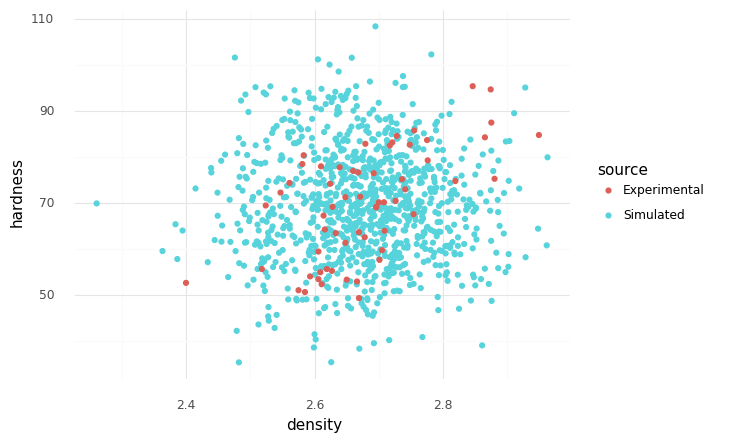

<ggplot: (8744240565745)>

In [5]:
## NOTE: No need to edit
# Build a model 
md_independence = (
    gr.Model("Independent Properties")
    >> gr.cp_marginals(
        density=gr.marg_fit("norm", df_shewhart.density),
        hardness=gr.marg_fit("norm", df_shewhart.hardness),
    )
    ## NOTE: This line is where things go wrong!
    # We can't just assume variables are independent
    # unless we have a good reason to do so.
    >> gr.cp_copula_independence()
)

# Draw simulated observations
(
    md_independence
    >> gr.ev_sample(n=1e3, df_det="nom", skip=True)
    >> gr.tf_mutate(source="Simulated")
    >> gr.tf_bind_rows(
        df_shewhart
        >> gr.tf_mutate(source="Experimental")
    )
    
    >> gr.ggplot(gr.aes("density", "hardness"))
    + gr.geom_point(gr.aes(color="source"))
    + gr.theme_minimal()
)

Notice that this model does not respect the correlation we observe in the data. How can we fix this?


# Marginal-Copula Approach

It turns out there is a drop-in solution for representing dependency; a [*copula*](https://en.wikipedia.org/wiki/Copula_(probability_theory)) is a mathematical tool to represent dependency between two (or more) random variables. We can fit a gaussian copula to represent the correlation we see between `hardness` and `density`.


eval_sample() is rounding n...
Design runtime estimates unavailable; model has no timing data.


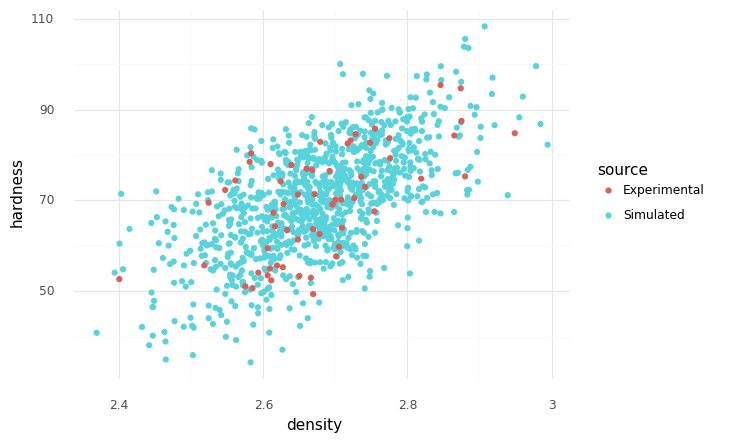

<ggplot: (8744240524791)>

In [6]:
## NOTE: No need to edit
# Build a model 
md_copula = (
    gr.Model("Independent Properties")
    >> gr.cp_marginals(
        density=gr.marg_fit("norm", df_shewhart.density),
        hardness=gr.marg_fit("norm", df_shewhart.hardness),
    )
    ## KEY DIFFERENCE: Fit a gaussian copula
    >> gr.cp_copula_gaussian(df_data=df_shewhart)
)

# Draw simulated observations
(
    md_copula
    >> gr.ev_sample(n=1e3, df_det="nom", skip=True)
    >> gr.tf_mutate(source="Simulated")
    >> gr.tf_bind_rows(
        df_shewhart
        >> gr.tf_mutate(source="Experimental")
    )
    
    >> gr.ggplot(gr.aes("density", "hardness"))
    + gr.geom_point(gr.aes(color="source"))
    + gr.theme_minimal()
)

Note that this version of the model respects the correlation in the data!


## Steps

When fitting a density for *multiple* uncertainties, we should follow an extended process:

1. Fit a marginal for each uncertain quantity
    - Follow the process from `e-grama06-fit-univar`; this should include checking for statistical control!
2. Fit a copula to relate the uncertain quantities
3. Assess the model


# Case Study: Circuit Performance

To illustrate the full distribution-fitting process, we'll work through a case study of circuit performance.


In [7]:
## NOTE: No need to edit
from grama.models import make_prlc_rand
md_circuit = make_prlc_rand()
md_circuit

/home/zach/Git/py_grama/grama/marginals.py:336: RuntimeWarning: divide by zero encountered in double_scalars


model: RLC with component tolerances

  inputs:
    var_det:
      L: [1e-09, 0.001]
      C: [0.001, 100]
      R: [0.001, 1.0]

    var_rand:
      dR: (+0) uniform, {'mean': '0.000e+00', 's.d.': '3.000e-02', 'COV': inf, 'skew.': 0.0, 'kurt.': 1.8}
      dL: (+0) uniform, {'mean': '0.000e+00', 's.d.': '6.000e-02', 'COV': inf, 'skew.': 0.0, 'kurt.': 1.8}
      dC: (+0) uniform, {'mean': '3.000e-01', 's.d.': '2.900e-01', 'COV': 0.96, 'skew.': 0.0, 'kurt.': 1.8}

    copula:
      Independence copula

  functions:
      f0: ['R', 'dR', 'L', 'dL', 'C', 'dC'] -> ['Rr', 'Lr', 'Cr']
      f1: ['Lr', 'Cr'] -> ['omega0']
      parallel RLC: ['omega0', 'Rr', 'Cr'] -> ['Q']

This circuit model has variability in its performance due to manufacturing variability. If we inspect its two outputs `Q` and `omega0`, we can see that they are quite variable, and exhibit a strong negative correlation.


eval_sample() is rounding n...


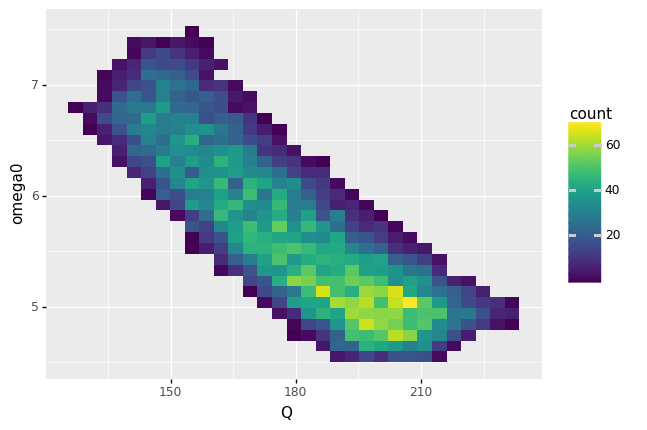

<ggplot: (8744240704705)>

In [8]:
## NOTE: No need to edit
df_circuit = (
    md_circuit
    >> gr.ev_sample(n=1e4, df_det="nom", seed=101)
)

(
    df_circuit
    >> gr.ggplot(gr.aes("Q", "omega0"))
    + gr.geom_bin2d()
)

## Marginals

First, let's fit distributions for the two quantities `Q` and `omega0` separately.


### __q1__ Check for statistical control

Check for statistical control of the output `omega0`. Use a large batch size. Answer the questions under *observations* below.


/home/zach/Git/py_grama/grama/tran_pivot.py:570: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/zach/Bin/anaconda3/envs/evc/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/zach/Bin/anaconda3/envs/evc/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/zach/Bin/anaconda3/envs/evc/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


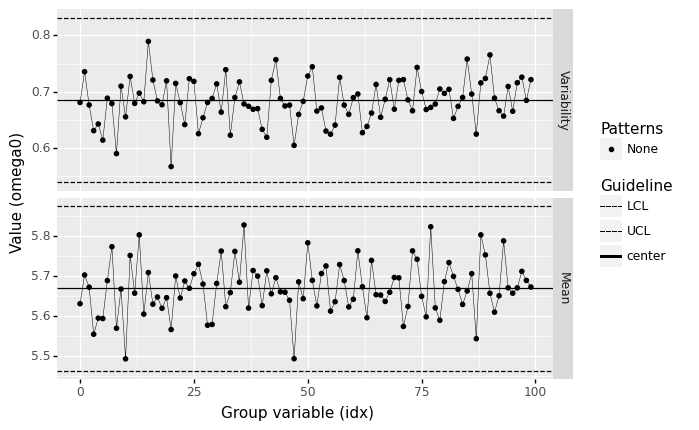

<ggplot: (8744243109816)>

In [9]:
## TASK: Make a control chart of batch size n_batch = 10
(
    df_circuit
    >> gr.tf_mutate(idx=DF.index // 100)
    >> gr.pt_xbs(group="idx", var="omega0")
)

*Observations*

- What batch size did you choose?
  - I chose a batch size of `n_batch = 100`.
- Does this process seem to be under statistical control?
  - Yes; there are not too many outlier batches, and there are no other suspicious patterns.
- Remind me: Is this quantity random? How do you know?
  - Yes! We generated these data as a random sample; they are random by-construction.


### __q2__ Fit a marginal for `omega0`

Select a reasonable distribution for `omega0` and fit it using the data `df_circuit.omega0`. Answer the questions under *observations* below.


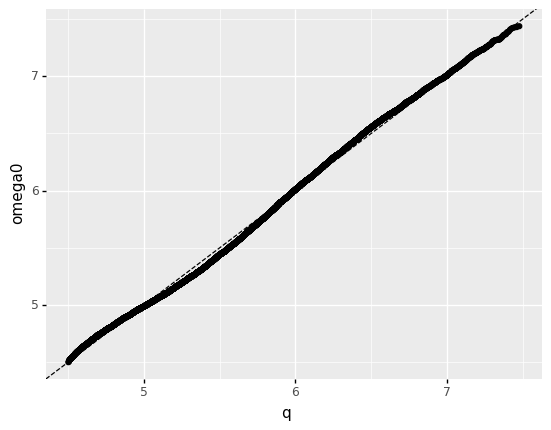

<ggplot: (8744240478284)>

In [10]:
## TASK: Fit a marginal for `omega0`

mg_omega0 = gr.marg_fit("beta", df_circuit.omega0)
## NOTE: Use the following to help check your work
(
    df_circuit
    >> gr.tf_mutate(q=gr.qqvals(DF.omega0, marg=mg_omega0))
    >> gr.ggplot(gr.aes("q", "omega0"))
    + gr.geom_abline(intercept=0, slope=1, linetype="dashed")
    + gr.geom_point()
)

*Observations*

- How well does your distribution fit the data?
  - Quite well! There is some inaccuracy in the left tail, but overall it agrees nicely.


### __q3__ Fit a marginal for `Q`

Select a reasonable distribution for `Q` and fit it using the data `df_circuit.Q`. Answer the questions under *observations* below.


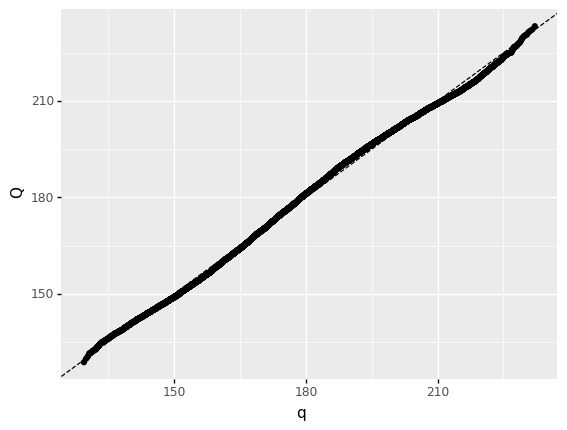

<ggplot: (8744240496150)>

In [11]:
## TASK: Fit a marginal for `Q`

mg_Q = gr.marg_fit("beta", df_circuit.Q)
## HINT: Use the assessment techniques discussed in 
# the previous exercise
(
    df_circuit
    >> gr.tf_mutate(q=gr.qqvals(DF.Q, marg=mg_Q))
    >> gr.ggplot(gr.aes("q", "Q"))
    + gr.geom_abline(intercept=0, slope=1, linetype="dashed")
    + gr.geom_point()
)
# solution-end

*Observations*

- How well does your distribution fit the data?
  - Quite well! There is some wavering throughout, but the overall shape is correct.


## Copula

Now that we've fit marginals for `Q` and `omega0`, we can work on representing their dependency.

The following code fits a model that neglects the dependency between `Q` and `omega0`. You will fit a gaussian copula and compare against this baseline model.


In [12]:
## NOTE: No need to edit
md_out_independence = (
    gr.Model("Circuit Output: Independence")
    >> gr.cp_marginals(
        omega0=mg_omega0,
        Q=mg_Q,
    )
    >> gr.cp_copula_independence()
)

md_out_independence 


model: Circuit Output: Independence

  inputs:
    var_det:

    var_rand:
      omega0: (+0) beta, {'mean': '5.680e+00', 's.d.': '6.700e-01', 'COV': 0.12, 'skew.': 0.34, 'kurt.': 2.27}
      Q: (+0) beta, {'mean': '1.793e+02', 's.d.': '2.142e+01', 'COV': 0.12, 'skew.': 0.05, 'kurt.': 2.25}

    copula:
      Independence copula

  functions:

### __q4__ Fit a gaussian copula

Add a gaussian copula to the model `md_out_copula`.

*Hint*: The code above demonstrates how to add a gaussian copula to a grama model.


In [13]:
## TASK: Fit a gaussian copula model
md_out_copula = (
    gr.Model("Circuit Output: Copula")
    >> gr.cp_marginals(
        omega0=mg_omega0,
        Q=mg_Q,
    )
    >> gr.cp_copula_gaussian(df_data=df_circuit)
)

## NOTE: Do not edit; use this to check your work
assert \
    isinstance(md_out_copula.density.copula, gr.CopulaGaussian), \
    "md_out_copula must have a gaussian copula"

md_out_copula 


model: Circuit Output: Copula

  inputs:
    var_det:

    var_rand:
      omega0: (+0) beta, {'mean': '5.680e+00', 's.d.': '6.700e-01', 'COV': 0.12, 'skew.': 0.34, 'kurt.': 2.27}
      Q: (+0) beta, {'mean': '1.793e+02', 's.d.': '2.142e+01', 'COV': 0.12, 'skew.': 0.05, 'kurt.': 2.25}

    copula:
      Gaussian copula with correlations:
     var1 var2      corr
0  omega0    Q -0.817849

  functions:

### __q5__ Compare the models

Use the following code to compare the multivariate models; answer the questions under *observations* below.


eval_sample() is rounding n...
Design runtime estimates unavailable; model has no timing data.
eval_sample() is rounding n...
Design runtime estimates unavailable; model has no timing data.


/home/zach/Bin/anaconda3/envs/evc/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


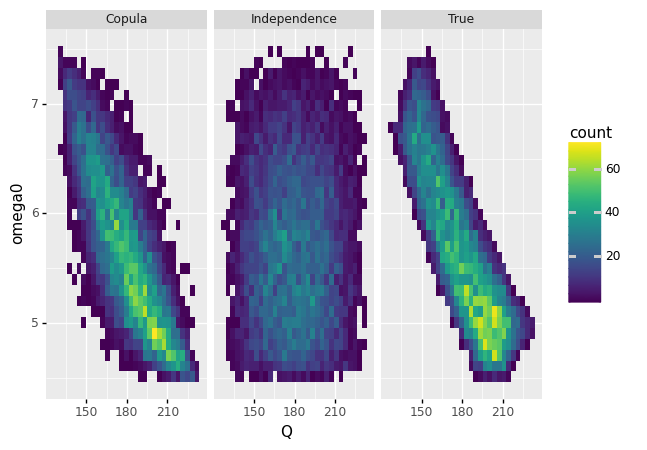

<ggplot: (8744240495821)>

In [14]:
## NOTE: No need to edit
(
    df_circuit
    >> gr.tf_mutate(source="True")
    >> gr.tf_bind_rows(
        md_out_independence
        >> gr.ev_sample(n=1e4, df_det="nom", skip=True)
        >> gr.tf_mutate(source="Independence")
    )
    >> gr.tf_bind_rows(
        md_out_copula
        >> gr.ev_sample(n=1e4, df_det="nom", skip=True)
        >> gr.tf_mutate(source="Copula")
    )
    
    >> gr.ggplot(gr.aes("Q", "omega0"))
    + gr.geom_bin2d()
    + gr.facet_wrap("source")
)

*Observations*

- How well does the independence model represent the true data?
  - Abysmal! The independence model does a terrible job representing the true data. For instance, the independence model does not capture the concentration of values at high `Q` and low `omega0`.
- What aspects does the copula model get *correct*?
  - The copula model gets the rough correlation correct, and correctly concentrates towards high `Q` and low `omega0`.
- What aspects does the copula model get *incorrect*?
  - The copula model "bows" along the edges, whereas the true data has a very "sharp" edge to the observations, almost like a bar.
<!-- solution-end -->